<a href="https://colab.research.google.com/github/bcrompvoets/Star_Formation/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project - PHYS 555 - Instructor: Seb Fabbro

## Breanna Crompvoets and Samuel Fielder

## Project Summary and Goals
Young Stellar Objects (YSOs) are newly forming stars which are yet to begin burning. They are split into different classes depending on their dust/gas envelope to protostar ratio; Class 0 having the greatest envelope and Class III no longer having an envelope. Due to the different ratios of envelope to protostar, each class appears differently in spectroscopy; thus the difference in fluxes between Spitzer IRAC bands are able to determine which class the data comes from. This project will focus on using the same data as Cornu and Montillaud (2021; CM21) to classify data points into three classes: Class I, Class II, and Contaminants. Only these three classes out of the original 9 available are chosen as Class 0 is too dusty to detect, and Class III is difficult to distinguish from regular stars. Furthermore, the contaminating classes (galaxies, shocks, stars, and PAHs) are of less concern -- we would like the algorithms to focus on distinguishing Class I and Class II from the rest. The original paper uses a multi-layer perceptron (MLP) with one hidden layer (20 neurons). Their results are presented in the below table.

|Class | Recall | Precision |
| --- | --- | --- |
|1 | 94.0% | 79.1 %|
|2 | 96.7% | 90.6% | 
|Other | 98.7%| 99.8%| 

The data for this project was pulled from https://cdsarc.cds.unistra.fr/viz-bin/cat/J/A+A/647/A116. These data include columns for four Spitzer IRAC bands (3.6 $\mu m$, 4.5 $\mu m$, 5.8 $\mu m$, and 8 $\mu m$) fluxes and errors, as well as from one Spitzer MIPS band (24 $\mu m$), along with the target values as determined via a manual classification scheme and the predicted data from CM21. We will only be using the four IRAC bands and their associated errors, as the MIPS band does not provide data for most objects. We use the same target values as they do for accurate comparison. 

This project seeks to use a multitude of algorithms learned over the semester to measure their effectiveness and compare it to the recreated MLP of CM21. These algorithms include: GridSearch with an SVC, GridSearch with a Logistic Regressor, a Stacking Ensemble with an SVC and a Logistic Regressor, a Gradient Boosting ensemble, a Random Forest ensemble, and an XGBoost ensemble. We also created our own MLP based off of their prescription. The workload was split as follows: B. Crompvoets completed the data cleaning and all other algorithms besides the MLP, and S. Fielder completed an MLP close to that of CM21, as well as creating a custom data loader/split. They communicated together on the best hyper-parameters to test.


## Import Libraries and set global variables

In [ ]:
# import statements
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# classic ML libraries
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,  GridSearchCV
import xgboost as xgb

# custom made libraries
from custom_dataloader import replicate_data

In [ ]:
# settings for confusion matrix plots and classification reports
cm_blues = plt.cm.Blues
custom_labs = ['Class 1', 'Class 2', 'Others']

# Classical ML Techniques

For each of the below algorithms we ran a gridsearch over a wide variety of hyperparameters. These parameter dictionaries are commented out in each cell, and we use the best parameters as a sample here to show how each algorithm performed. This section of the project was conducted by B. Crompvoets.

We conducted these fits for each of three data splits:
* "75/25" -- here the data is split into 75% training, 25% test set.
* "300s" -- here the data is split such that 5 out of the 7 subclasses, each has 300 members in the training set (2 do not have enough members). The test set size is the same as CM21. The data is again split into only 3 classes to train/test.
* "CM21" -- here the data is split with the exact same values as CM21 provide in their paper.

An example of a run with the 75/25 split is given below, with best results for each of the other runs commented out, as well as the parameter grid tested for each GridSearch. The results of all runs will be included at the end of this document.

## Loading Data Set

In [ ]:
# data load
X = np.load("Input_Class_AllClasses_Sep.npy")
Y = np.load("Target_Class_AllClasses_Sep.npy")

# custom data loader to pull in custom sized data set
# use seed to get replicable results for now
seed_val = 1111

# the amounts below are how many of each class of object you want in the training set and validation set - leftover amounts given to testing set

# CM21 Split
# amounts_train = [331,1141,231,529,27,70,1257]
# amounts_val = [82, 531, 104, 278, 6, 17, 4359]

# 300s Split
# amounts_train = [300,300,300,300,27,70,300]
# amounts_val = [82, 531, 104, 278, 6, 17, 4359]

# 75/25 Split
amounts_train = [311,1994,391,1043,25,66,21796] #75/25 train
amounts_val = [103,665,130,348,9,22,5449] #75/25 val

# calling custom datagrabber here
inp_tr, tar_tr, inp_va, tar_va, inp_te, tar_te = replicate_data(X, Y, 'three', amounts_train, amounts_val, seed_val)

# scaling data according to training inputs
scaler_S = StandardScaler().fit(inp_tr)
inp_tr = scaler_S.transform(inp_tr)
inp_va = scaler_S.transform(inp_va)

# COMMENT NEXT LINE IF RUNNING 75/25 SPLIT
# inp_te = scaler_S.transform(inp_te) # Comment out for 75/25 split

# printouts for double checking all the sets and amounts
print('Sizes of Datasets : Inputs , Targets')
print('------------------------------------')
print(f'Training set: {inp_tr.shape} , {tar_tr.shape} \nValidation set: {inp_va.shape} , {tar_va.shape} \nTesting Set: {inp_te.shape}, {tar_te.shape}')
print('------------------------------------')

Sizes of Datasets : Inputs , Targets
------------------------------------
Training set: (25626, 8) , (25626,) 
Validation set: (1277, 8) , (1277,) 
Testing Set: (0, 8), (0,)
------------------------------------


/Users/breannacrompvoets/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


## Logistic Regression

In [ ]:
%%time

# Specifying logistic regression
logreg = LogisticRegression()

# hyperparameters tested over initially
# param_grid = [{'penalty': ['l1'], 'max_iter': np.arange(300,1500,100),
#         'solver': ['liblinear', 'saga'], 'tol': np.arange(0.0001,0.01,0.0005)},
#         {'penalty': ['l2'], 'max_iter': np.arange(300,1500,100),
#         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'tol': np.arange(0.0001,0.01,0.0005)},
#         {'penalty': ['elasticnet'], 'max_iter': np.arange(100,2000,100), 'l1_ratio': np.arange(0.1,1.,0.1),
#         'solver': ['saga'], 'tol': np.arange(0.0001,0.01,0.0005)}]

# actual hyperparameters used
# 75/25
param_grid = [{ 'penalty': ['l1'],
                'max_iter': [500],
                'solver': ['saga'],
                'tol': [0.0001]}]
# 300s
# param_grid = [{ 'penalty': ['l1'],
#                 'max_iter': [300],
#                 'solver': ['saga'],
#                 'tol': [0.0016]}]
# CM21
# param_grid = [{ 'penalty': ['l1'],
#                 'max_iter': [600],
#                 'solver': ['saga'],
#                 'tol': [0.0001]}]

# Define the grid
grid = GridSearchCV(logreg,param_grid=param_grid, verbose=1)

# Run the data through the grid to find optimal results
grid.fit(inp_tr, tar_tr.ravel())

# Find the predicted values
pred_tr = grid.predict(inp_tr)
pred_va = grid.predict(inp_va)

In [ ]:
grid.best_params_

{'max_iter': 500, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.0001}

In [ ]:
# Confusion Matrix plot
# fig, ax = plt.subplots(1,2, figsize=(8,4))
# ConfusionMatrixDisplay.from_predictions(tar_tr, pred_tr, ax = ax[0], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)
# ConfusionMatrixDisplay.from_predictions(tar_va, pred_va, ax = ax[1], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)

# ax[0].set_title('Training Set')
# ax[1].set_title('Validation Set')
# plt.suptitle('Logistic Regression Results')
# plt.tight_layout()
# plt.show()


print(classification_report(tar_va, pred_va, target_names=custom_labs))

              precision    recall  f1-score   support

     Class 1       0.70      0.59      0.64       103
     Class 2       0.84      0.69      0.76       665
      Others       0.68      0.87      0.76       509

    accuracy                           0.75      1277
   macro avg       0.74      0.72      0.72      1277
weighted avg       0.77      0.75      0.75      1277



## SVM

In [ ]:
%%time

# Specifying svc
svc = SVC()

# Hyperparameters tested over initially
# param_grid = [{'kernel':['rbf','sigmoid','linear','poly'], 'gamma':['auto','scale'], 'C':np.arange(0.1,1.,0.1)}]

# Final hyperparameters
# 75/25
param_grid = [{'kernel':['rbf',],
               'gamma':['auto'],
               'C': [0.9]}]
# 300s
# param_grid = [{'C': [0.8], 'gamma': ['auto'], 'kernel': ['linear']}]
# CM21
# param_grid = [{'C': [0.9], 'gamma': ['auto'], 'kernel': ['rbf']}]

# Define the grid
grid = GridSearchCV(svc,param_grid=param_grid)

# Run the data through the grid to find optimal results
grid.fit(inp_tr, tar_tr.ravel())

# Find the predicted values
pred_tr = grid.predict(inp_tr)
pred_va = grid.predict(inp_va)

CPU times: user 21.9 s, sys: 137 ms, total: 22.1 s
Wall time: 22.1 s


In [ ]:
grid.best_params_

{'C': 0.9, 'gamma': 'auto', 'kernel': 'rbf'}

In [ ]:
# # Confusion Matrix plot
# fig, ax = plt.subplots(1,2, figsize=(8,4))
# ConfusionMatrixDisplay.from_predictions(tar_tr, pred_tr, ax = ax[0], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)
# ConfusionMatrixDisplay.from_predictions(tar_va, pred_va, ax = ax[1], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)

# ax[0].set_title('Training Set')
# ax[1].set_title('Validation Set')
# plt.suptitle('Support Vector Classification Results')
# plt.tight_layout()
# plt.show()

print(classification_report(tar_va, pred_va, target_names=custom_labs))

              precision    recall  f1-score   support

     Class 1       0.78      0.62      0.69       103
     Class 2       0.95      0.87      0.91       665
      Others       0.84      0.96      0.90       509

    accuracy                           0.89      1277
   macro avg       0.85      0.82      0.83      1277
weighted avg       0.89      0.89      0.88      1277



## SVM/LR Stacking Ensemble
No GridSearch, uses best pars as defined previously. Adding multiple SVC's does not improve results. 

In [ ]:
%%time

# Specify Gradient Boost
# 75/25
estimators = [('svc', SVC(kernel='rbf',gamma='auto',C=0.9,random_state=42))]
# 300s
# estimators = [('svc', SVC(C=0.8, gamma='auto', kernel='linear',random_state=42))]
# CM21 
# estimators = [('svc', SVC(C=0.9, gamma='auto', kernel='rbf',random_state=42))]


# As the parameters for the Logistic Regression didn't change much, we use the best pars from the first trial.
stacl = StackingClassifier(estimators=estimators,
                           final_estimator=LogisticRegression(penalty = 'l1', max_iter = 500, solver ='saga', tol =0.0001))


# Run the data through the stacking classifier
stacl.fit(inp_tr, tar_tr.ravel())

# Find the predicted values
pred_tr = stacl.predict(inp_tr)
pred_va = stacl.predict(inp_va)

CPU times: user 23.3 s, sys: 437 ms, total: 23.7 s
Wall time: 22.6 s


In [ ]:
# # Confusion Matrix plot
# fig, ax = plt.subplots(1,2, figsize=(8,4))
# ConfusionMatrixDisplay.from_predictions(tar_tr, pred_tr, ax = ax[0], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)
# ConfusionMatrixDisplay.from_predictions(tar_va, pred_va, ax = ax[1], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)

# ax[0].set_title('Training Set')
# ax[1].set_title('Validation Set')
# plt.suptitle('Stacking Results')
# plt.tight_layout()
# plt.show()


print(classification_report(tar_va, pred_va, target_names=custom_labs))

              precision    recall  f1-score   support

     Class 1       0.79      0.60      0.69       103
     Class 2       0.95      0.87      0.91       665
      Others       0.84      0.97      0.90       509

    accuracy                           0.89      1277
   macro avg       0.86      0.81      0.83      1277
weighted avg       0.89      0.89      0.88      1277



## Gradient Boosting

In [ ]:
%%time

# Specify Gradient Boost
boostcl = GradientBoostingClassifier()

# Hyperparameters tested over initially
# param_grid = [{'n_estimators': np.arange(50,250,50),'subsample':[0.5,1.0],
#               'criterion':['friedman_mse'],'n_iter_no_change':[5],'warm_start':[True,False],
#               'max_depth':np.arange(1,11,2),'max_features': ['sqrt','log2']}]

# Final hyperparameters
# 75/25
param_grid = [{'criterion': ['friedman_mse'],
                'max_depth': [9],
                'max_features': ['log2'],
                'n_estimators': [50],
                'n_iter_no_change': [5],
                'subsample': [1.0],
                'warm_start': [True]}]
# 300s
# param_grid = [{'criterion': ['friedman_mse'],
#               'max_depth': [5],
#               'max_features': ['log2'],
#               'n_estimators': [150],
#               'n_iter_no_change': [5],
#               'subsample': [1.0],
#               'warm_start': [False]}]
# CM21
# param_grid = [{'criterion': ['friedman_mse'],
#               'max_depth': [7],
#               'max_features': ['log2'],
#               'n_estimators': [200],
#               'n_iter_no_change': [5],
#               'subsample': [1.0],
#               'warm_start': [True]}]


# Define the grid
grid = GridSearchCV(boostcl, param_grid)

# Run the data through the grid to find optimal results
grid.fit(inp_tr, tar_tr.ravel())

# Find the predicted values
pred_tr = grid.predict(inp_tr)
pred_va = grid.predict(inp_va)

CPU times: user 23.2 s, sys: 111 ms, total: 23.3 s
Wall time: 23.4 s


In [ ]:
grid.best_params_

{'criterion': 'friedman_mse',
 'max_depth': 9,
 'max_features': 'log2',
 'n_estimators': 50,
 'n_iter_no_change': 5,
 'subsample': 1.0,
 'warm_start': True}

In [ ]:
# # Confusion Matrix plot
# fig, ax = plt.subplots(1,2, figsize=(8,4))
# ConfusionMatrixDisplay.from_predictions(tar_tr, pred_tr, ax = ax[0], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)
# ConfusionMatrixDisplay.from_predictions(tar_va, pred_va, ax = ax[1], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)

# ax[0].set_title('Training Set')
# ax[1].set_title('Validation Set')
# plt.suptitle('Gradient Boosting Results')
# plt.tight_layout()
# plt.show()

print(classification_report(tar_va, pred_va, target_names=custom_labs))

              precision    recall  f1-score   support

     Class 1       0.77      0.60      0.67       103
     Class 2       0.95      0.89      0.92       665
      Others       0.87      0.97      0.91       509

    accuracy                           0.90      1277
   macro avg       0.86      0.82      0.84      1277
weighted avg       0.90      0.90      0.90      1277



### XGBoost

In [ ]:
# Specify XGBoost
xgbcl = xgb.XGBClassifier()

# Hyperparameters tested over initially
# param_grid = [{'subsample':[0.5,1.0],'max_depth':np.arange(1,11,2),'sampling_method':['uniform']}]

# Final hyperparameters
# 75/25
param_grid = [{'max_depth': [9], 'sampling_method': ['uniform'], 'subsample': [0.5]}]
# 300s
# param_grid = [{'max_depth': [7], 'sampling_method': ['uniform'], 'subsample': [0.5]}]
# CM21
# param_grid = [{'max_depth': [9], 'sampling_method': ['uniform'], 'subsample': [1.0]}]

# Define the grid
grid = GridSearchCV(xgbcl, param_grid)

# Run the data through the grid to find optimal results
grid.fit(inp_tr, tar_tr.ravel())

# Find the predicted values
pred_tr = grid.predict(inp_tr)
pred_va = grid.predict(inp_va)

[13:05:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/breannacrompvoets/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/breannacrompvoets/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:05:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/breannacrompvoets/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:05:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/breannacrompvoets/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:05:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/breannacrompvoets/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:05:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/breannacrompvoets/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:05:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
grid.best_params_

{'max_depth': 9, 'sampling_method': 'uniform', 'subsample': 0.5}

In [ ]:
# # Confusion Matrix plot
# fig, ax = plt.subplots(1,2, figsize=(8,4))
# ConfusionMatrixDisplay.from_predictions(tar_tr, pred_tr, ax = ax[0], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)
# ConfusionMatrixDisplay.from_predictions(tar_va, pred_va, ax = ax[1], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)

# ax[0].set_title('Training Set')
# ax[1].set_title('Validation Set')
# plt.suptitle('XGBoost Results')
# plt.tight_layout()
# plt.show()

print(classification_report(tar_va, pred_va, target_names=custom_labs))

              precision    recall  f1-score   support

     Class 1       0.86      0.75      0.80       103
     Class 2       0.96      0.91      0.93       665
      Others       0.89      0.97      0.93       509

    accuracy                           0.92      1277
   macro avg       0.90      0.88      0.89      1277
weighted avg       0.92      0.92      0.92      1277



## Random Forest

In [ ]:
# Specify RF
rfcl = RandomForestClassifier()

# Hyperparameters tested over initially
# param_grid = [{'class_weight': ['balanced_subsample','balanced'], 'n_estimators': np.arange(50,250,50),
#         'criterion': ['gini', 'entropy'], 'max_features': ['sqrt','log2'], 'oob_score':[True,False]}]

# Final hyperparameters
# 75/25
param_grid = [{'class_weight': ['balanced_subsample'],
              'criterion': ['entropy'],
              'max_features': ['log2'],
              'n_estimators': [150],
              'oob_score': [False]}]
# 300s
# param_grid = [{'class_weight': ['balanced'],
#               'criterion': ['entropy'],
#               'max_features': ['log2'],
#               'n_estimators': [50],
#               'oob_score': [False]}]
# CM21
# param_grid = [{'class_weight': ['balanced'],
#               'criterion': ['entropy'],
#               'max_features': ['log2'],
#               'n_estimators': [100],
#               'oob_score': [True]}]

# Define the grid
grid = GridSearchCV(rfcl,param_grid=param_grid)

# Run the data through the grid to find optimal results
grid.fit(inp_tr, tar_tr.ravel())

# Find the predicted values
pred_tr = grid.predict(inp_tr)
pred_va = grid.predict(inp_va)

In [ ]:
grid.best_params_

{'class_weight': 'balanced_subsample',
 'criterion': 'entropy',
 'max_features': 'log2',
 'n_estimators': 150,
 'oob_score': False}

In [ ]:
# # Confusion Matrix plot
# fig, ax = plt.subplots(1,2, figsize=(8,4))
# ConfusionMatrixDisplay.from_predictions(tar_tr, pred_tr, ax = ax[0], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)
# ConfusionMatrixDisplay.from_predictions(tar_va, pred_va, ax = ax[1], normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)

# ax[0].set_title('Training Set')
# ax[1].set_title('Validation Set')
# plt.suptitle('Random Forest Results')
# plt.tight_layout()
# plt.show()

print(classification_report(tar_va, pred_va, target_names=custom_labs))

              precision    recall  f1-score   support

     Class 1       0.82      0.67      0.74       103
     Class 2       0.95      0.91      0.93       665
      Others       0.89      0.97      0.93       509

    accuracy                           0.91      1277
   macro avg       0.89      0.85      0.86      1277
weighted avg       0.91      0.91      0.91      1277



In [ ]:
import os
os.system('say "your program has finished"')

0

# Neural Network

In this section, we describe in which ways we replicated the CM21 paper, and the choices we made along the way to derive the best results we were able to achieve.

All the training has been performed prior to this notebook, and the state of the network saved at the appropriate time. Below we will just import the state of the system described, and run the testing set through for evaluation, and metrics along with Confusion Matrixes will be outputted for each subsection.

Many of the functions called below are semi-custom made, and are found in the appropriate `.py` files in this directory. The majority come from `NN_Defs.py` where the model construction along with the training and validation functions are located. Additionally, our custom data split maker is found in `custom_dataloader.py`, in which we can build reproducable sets of training, validation and testing sets depending on the number of subclasses wanted in each set.

Finally `network_runner.py` was the script used in order to train all of the networks, and appropriately print out the metrics, along with saving plots for both confusion matrixes and loss values. Some of these outputs are shown in the `Saved_Final_Data/` directory. The settings found therein will be imported below to load the state of the networks as mentioned above.

## Importing

In [ ]:
# library imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

# custom script inputs
from NN_Defs import get_n_params, train, validate, BaseMLP

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Running on : {device}')

datadir = 'Saved_Final_Data/'

Running on : cpu


## Data Loading

In [ ]:
# data load
X = np.load("Input_Class_AllClasses_Sep.npy")
Y = np.load("Target_Class_AllClasses_Sep.npy")

# custom data loader to pull in custom sized data set
# use seed to get replicable results for now
seed_val = 1111

# the amounts below are how many of each class of object you want in the training set and validation set - leftover amounts given to testing set

# CM21 Split
amounts_train = [331,1141,231,529,27,70,1257]
amounts_val = [82, 531, 104, 278, 6, 17, 4359]

# calling custom datagrabber here
inp_tr, tar_tr, inp_va, tar_va, inp_te, tar_te = replicate_data(X, Y, 'three', amounts_train, amounts_val, seed_val)

# scaling data according to training inputs
scaler_S = StandardScaler().fit(inp_tr)
inp_tr = scaler_S.transform(inp_tr)
inp_va = scaler_S.transform(inp_va)
inp_te = scaler_S.transform(inp_te) # Comment out for 75/25 split

# printouts for double checking all the sets and amounts
print('Sizes of Datasets : Inputs , Targets')
print('------------------------------------')
print(f'Training set: {inp_tr.shape} , {tar_tr.shape} \nValidation set: {inp_va.shape} , {tar_va.shape} \nTesting Set: {inp_te.shape}, {tar_te.shape}')
print('------------------------------------')

Sizes of Datasets : Inputs , Targets
------------------------------------
Training set: (3586, 8) , (3586,) 
Validation set: (5377, 8) , (5377,) 
Testing Set: (17940, 8), (17940,)
------------------------------------


/opt/anaconda3/envs/PHYS555_PY37/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


## Scaling, Conversions to Tensors, and DataLoader Creation

In [ ]:
# creation of tensor instances
inp_tr = torch.tensor(inp_tr)
tar_tr = torch.tensor(tar_tr)
inp_va = torch.tensor(inp_va)
tar_va = torch.tensor(tar_va)
inp_te = torch.tensor(inp_te)
tar_te = torch.tensor(tar_te)

# pass tensors into TensorDataset instances
train_data = data_utils.TensorDataset(inp_tr, tar_tr)
val_data = data_utils.TensorDataset(inp_va, tar_va)
test_data = data_utils.TensorDataset(inp_te, tar_te)

# constructing data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=25, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=25, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=25, shuffle=True)

## Create Network Instance and Set Hyperparameters

The CM21 paper provided a good amount of detail about how the network was set up, including number of layers, number of neurons, how the data set was split for training and validation, etc. CM21 did mention that at every 3000 and 5000 epochs in training, they would check their metric to see if a reduction in learning rate would be useful, however they do not say conclusively if they implemented any learning rate scheduling.

We decided, as a starting point to implement the quoted learning rate of $4 \times10^{-5}$ statically throughout training, to see if decent results would emerge from a few thousand epochs of training.

Additionally, we would like to mention that after a stable network that produced decent results was built, going back and changing the batch size did not significantly affect the results, hence these will be kept at the constant size of 25 throughout the results presented here.

## Initial Results

In [ ]:
# create nn instance
BaseNN = BaseMLP(8, 20, 3)
# load in saved state of network
loadpath = datadir+'CSplit_LR4e-5_B25_E20k_M06_Settings'
BaseNN.load_state_dict(torch.load(loadpath, map_location=device))

# compute validation results
val_loss, val_accuracy, val_predictions, val_truth_values = validate(BaseNN, val_loader, device)

At the time of training, training and validation losses were also stored and plotted. This is loaded in manually here from `/Saved_Final_Data`.

<img src="Saved_Final_Data/CSplit_LR4e-5_B25_E20k_M06_loss.png" alt="Loss with 4e-5 Learning Rate" width="750"/>

As we can see from the above plot, the training and validation sets are still decreasing in value after 20000 epochs. We can additionally display our metrics as well as a Confusion Matrix.

              precision    recall  f1-score   support

     Class 1       0.00      0.00      0.00        82
     Class 2       0.33      0.75      0.45       531
      Others       0.96      0.84      0.90      4764

    accuracy                           0.82      5377
   macro avg       0.43      0.53      0.45      5377
weighted avg       0.89      0.82      0.84      5377



/opt/anaconda3/envs/PHYS555_PY37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/PHYS555_PY37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/PHYS555_PY37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


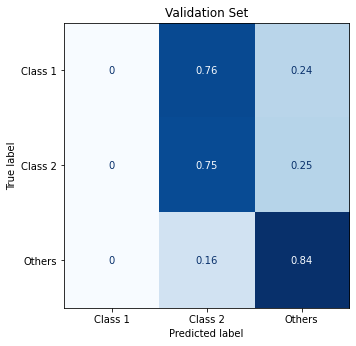

In [ ]:
# print classification report
print(classification_report(val_truth_values, val_predictions, target_names=custom_labs))

# plotting Confusion Matrix and saving
fig, ax = plt.subplots(figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(val_truth_values, val_predictions, ax = ax, normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)
ax.set_title('Validation Set')
plt.tight_layout()
plt.show()

## A more aggressive approach

We found from above, that taking a static learning rate of very low value, yielded learning that was very slow. Of course when the learning rate is low, the step size for the SGD is so small that it will need quite a bit of time to yield necessary results that are comparable to the paper. From the confusion matrix above, we know that the model at it's early stages does a great job at classifying the "Others" class as well as the Class II objects, but the network is not yet picking up the differences between Class I and Class II objects.

What is needed are larger learning rate steps by the optimizer, to speed up the process of finding a suitable minimum which produces the results closer to CM21's results. This time to converge is what we ended up tuning our network to produce.

Below, we will load in the network that was trained with a learning rate of $4 \times 10^{-2}$ for 10,000 epochs.

In [ ]:
# create nn instance
BaseNN = BaseMLP(8, 20, 3)
# load in saved state of network
loadpath = datadir+'Final_CSplit_4e-2_Settings'
BaseNN.load_state_dict(torch.load(loadpath, map_location=device))

# compute validation results
val_loss, val_accuracy, val_predictions, val_truth_values = validate(BaseNN, val_loader, device)

Again, the loss plot below was constructed at our last epoch in this specific model loaded. This is loaded in manually here from `/Saved_Final_Data`.

<img src="Saved_Final_Data/Final_CSplit_4e-2_loss.png" alt="Loss with 4e-5 Learning Rate" width="750"/>

Surpringsly, we had not yet implemented any amount of learning rate scheduler, so to see the characteristic dip at around Epoch 1800 was surprising. This simply means that at that point in the model, the model fell into a minimum and plateaued from then on out.

              precision    recall  f1-score   support

     Class 1       0.76      0.87      0.81        82
     Class 2       0.86      0.93      0.89       531
      Others       0.99      0.98      0.99      4764

    accuracy                           0.98      5377
   macro avg       0.87      0.93      0.90      5377
weighted avg       0.98      0.98      0.98      5377



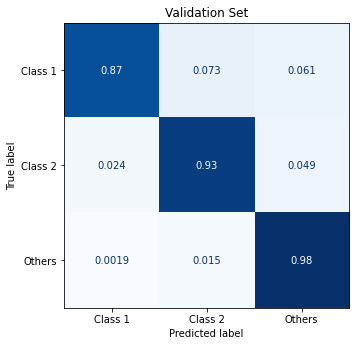

In [ ]:
# print classification report
print(classification_report(val_truth_values, val_predictions, target_names=custom_labs))

# plotting Confusion Matrix and saving
fig, ax = plt.subplots(figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(val_truth_values, val_predictions, ax = ax, normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)
ax.set_title('Validation Set')
plt.tight_layout()
plt.show()

With only 10,000 epochs, and a learning rate that is much more aggressive, we already see the network perform quite well compared to the small learning rate model shown previously. It seems we do not only converge faster, but we also converge to a lower loss value, yielding high recall for our classes.

The largest change with the more aggressive learning rate, is that the network is now able to distinguish between Class I and Class II objects more effectively. Whereas prior our recall was 0% for Class I objects, that is now 87% recall, while training for only half the time.

## Can we be even more aggressive?

In [ ]:
# create nn instance
BaseNN = BaseMLP(8, 20, 3)
# load in saved state of network
loadpath = datadir+'Final_CSplit_4e-1_Settings'
BaseNN.load_state_dict(torch.load(loadpath, map_location=device))

# compute validation results
val_loss, val_accuracy, val_predictions, val_truth_values = validate(BaseNN, val_loader, device)

Again, the loss plot below was constructed at our last epoch in this specific model loaded. This is loaded in manually here from `/Saved_Final_Data`.

<img src="Saved_Final_Data/Final_CSplit_4e-1_loss.png" alt="Loss with 4e-5 Learning Rate" width="750"/>

              precision    recall  f1-score   support

     Class 1       0.76      0.83      0.80        82
     Class 2       0.91      0.92      0.91       531
      Others       0.99      0.99      0.99      4764

    accuracy                           0.98      5377
   macro avg       0.89      0.91      0.90      5377
weighted avg       0.98      0.98      0.98      5377



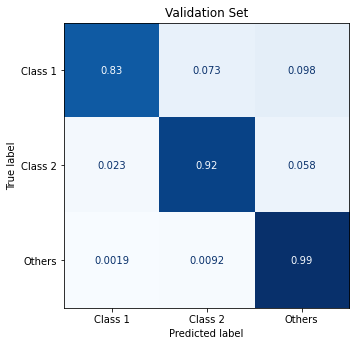

In [ ]:
# print classification report
print(classification_report(val_truth_values, val_predictions, target_names=custom_labs))

# plotting Confusion Matrix and saving
fig, ax = plt.subplots(figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(val_truth_values, val_predictions, ax = ax, normalize='true', cmap=cm_blues, display_labels=custom_labs, colorbar=False)
ax.set_title('Validation Set')
plt.tight_layout()
plt.show()

From the above results, we can see that implementing a learning rate that is too aggressive leads to convergence that is perhaps too quick, as we see the validation loss start to increase just past 3000 epochs. Overall, this network loses out to our previous value of learning rate, with a decrease in both recall for Class I and Class II objects.

> Todo:

Run low learning rate for 500,000 epochs to see if there some extreme plateau-ing happeneing.

Otherwise, this is where the summary and wrap up discussion will live.

# Results and Discussion

In the three images below we summarize the results of recall for each algorithm and our final MLP with each different data-split. We see that, if we are focused purely on achieving the best recall for Class I, then the SVM (with the "300's" split) is our best algorithm. However if we look across multiple classes, we find that the MLP (with CM21 split) does perform best, followed closely by XGBoost (also with CM21 split). 

These results indicate that classical ML methods are worth considering... **SAM THOUGHTS ON WHAT TO ADD HERE??**

It is worth noting that CM21 used a simplified, observer-biased, labelling scheme in order to originally label the target data. This scheme and it's associated errors means there is non-negligible probability for falsely labelled data. It is quite likely that the errors in some of our methods are direct results of the incorrectly labelled targets. Furthermore, our network and algorithms only made use of eight data columns, not ten as CM21 did. These last two columns are important for separating Class I from reddenned Class II and would hence further aid in the training if they were available. As the data in these columns is sparse, we chose not to use them. Improvements could then be made by using the predictions from CM21, following the statement they made that their network is more accurately predicting the target labels than the simplified labelling scheme originally did.

Recall Class I:

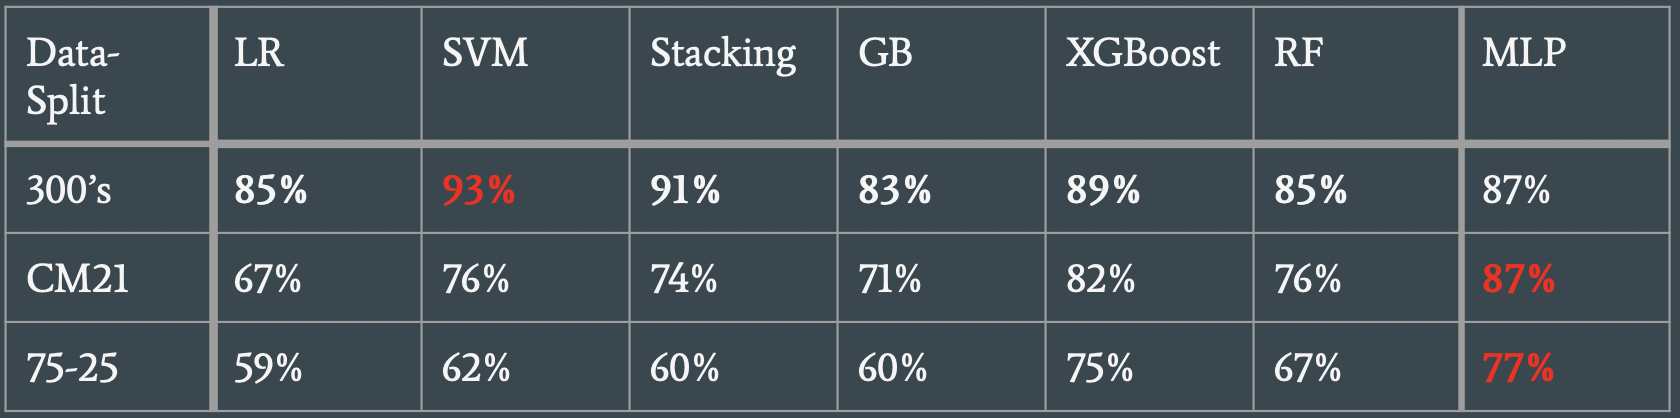

Recall Class II:
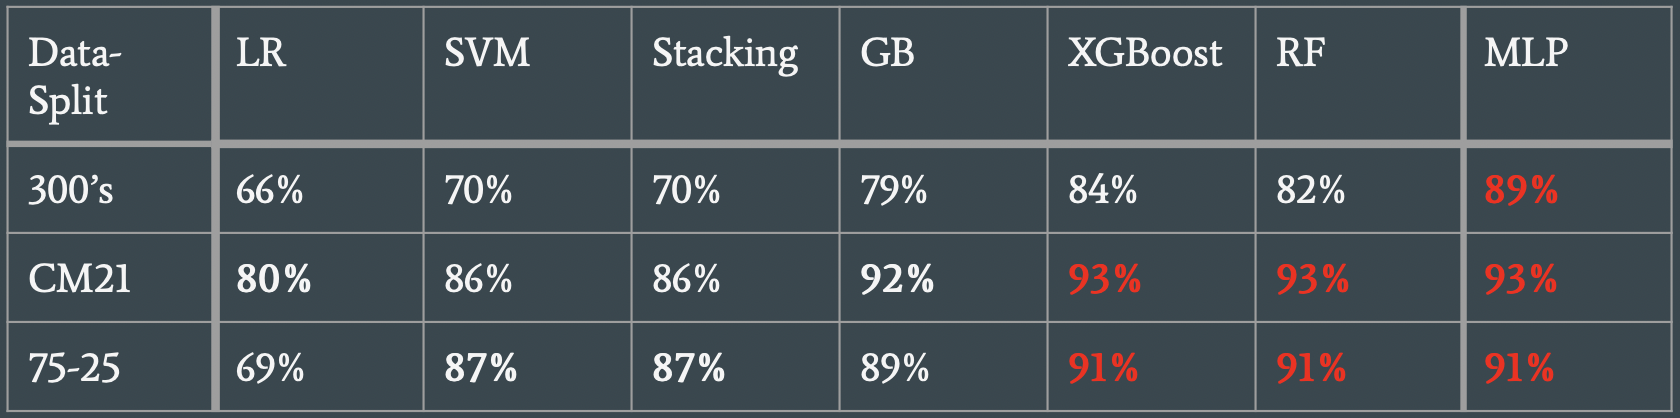

Recall Class III:
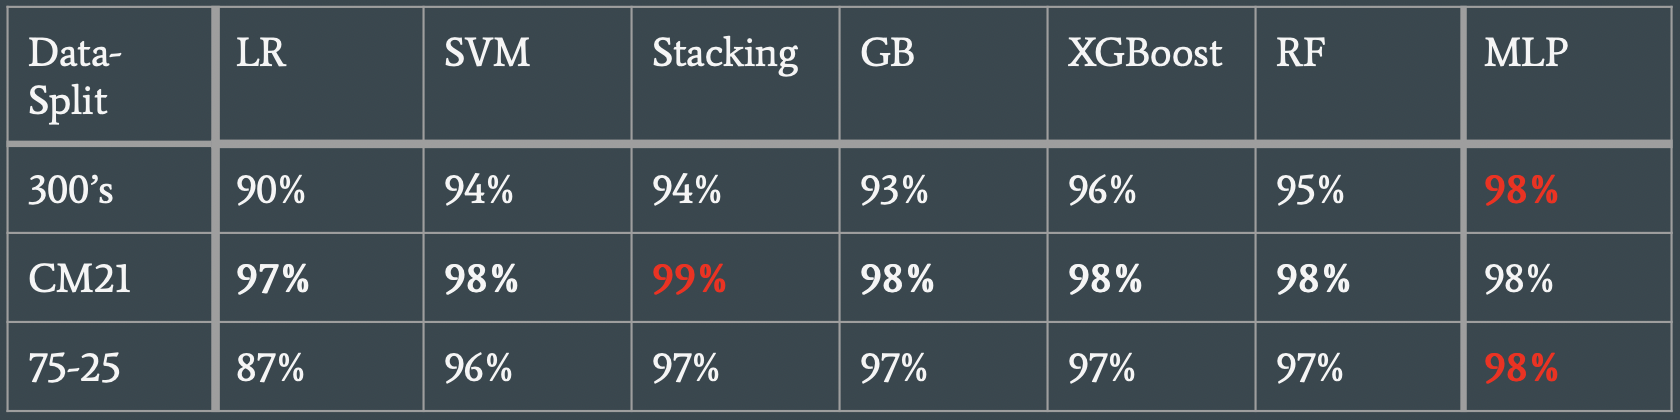